In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.my_random.event import BlockingEventSimulation, calculate_theoretical_block_pct
from scipy import stats
from dataclasses import dataclass
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def find_blocked_w_conf(sim: BlockingEventSimulation):
    blocked = []
    for i in range(10):
        blocked.append(sim.simulate(10_000, 10))

    mean = np.mean(blocked)
    sd = np.std(blocked)
    lwr, upr = stats.t.interval(0.95, 9)
    conf = [mean + sd/np.sqrt(10)*lwr, mean + sd/np.sqrt(10)*upr]

    return mean, conf 

## 1. Poisson Process

In [4]:
arr_dist = stats.expon()
serv_dist = stats.expon(scale=8)
pois_sim = BlockingEventSimulation(arr_dist, serv_dist)
blocked = []
for i in range(10):
    blocked.append(pois_sim.simulate(10_000, 10))




In [7]:
find_blocked_w_conf(pois_sim)

(0.11945000000000001, [0.11576063734857538, 0.12313936265142465])

In [37]:
calculate_theoretical_block_pct(10, 8)

0.12166106425295149

## 2. Renewal Processes


In [13]:
@dataclass
class hyper_exp:
    p1: float
    p2: float
    lmbda1: float
    lmbda2: float

    def rvs(self, size):
        return self.p1 * stats.expon.rvs(size=size, scale=1/self.lmbda1) \
            + self.p2*stats.expon.rvs(size=size, scale = 1/self.lmbda2)

In [14]:
arr_erl = stats.erlang(a=1)
arr_hyp = hyper_exp(0.8, .2, .8333, 5.0)
serv_dist = stats.expon(scale=8)



In [15]:

sim_erl = BlockingEventSimulation(arr_erl, serv_dist)
sim_hyp = BlockingEventSimulation(arr_hyp, serv_dist)


1.0

## Erlang arrival times

In [16]:
blocked = []
for i in range(10):
    blocked.append(sim_erl.simulate(10_000, 10))

mean = np.mean(blocked)
sd = np.std(blocked)
lwr, upr = stats.t.interval(0.95, 9)
conf = [mean + sd/np.sqrt(10)*lwr, mean + sd/np.sqrt(10)*upr]

mean, conf

(0.11786, [0.11363500739572827, 0.12208499260427175])

## Hyper Exponential Arrival Times

In [42]:
blocked = []
for i in range(10):
    blocked.append(sim_hyp.simulate(10_000, 10))

mean = np.mean(blocked)
sd = np.std(blocked)
lwr, upr = stats.t.interval(0.95, 9)
conf = [mean + sd/np.sqrt(10)*lwr, mean + sd/np.sqrt(10)*upr]

mean, conf

(0.11591, [0.11201390464069531, 0.11980609535930468])

## 3.) Service Distributions

In [9]:
@dataclass
class constant_service_time:
    mean_time: float
    def rvs(self, size):
        return np.array([self.mean_time]*size)

def pareto_mean_service(k, mean_time):
    scale = (k-1)*mean_time / k
    return stats.pareto(b = k, scale=scale)

arr_dist = stats.expon()
serv_const = constant_service_time(8)
serv_par_105 = pareto_mean_service(1.05, 8)
serv_par_205 = pareto_mean_service(2.05, 8)

const_sim = BlockingEventSimulation(arr_dist, serv_const)
par_105_sim = BlockingEventSimulation(arr_dist, serv_par_105)
par_205_sim = BlockingEventSimulation(arr_dist, serv_par_205)



In [16]:
def find_blocked_w_conf(sim: BlockingEventSimulation):
    blocked = []
    for i in range(10):
        blocked.append(sim.simulate(10_000, 10))

    mean = np.mean(blocked)
    sd = np.std(blocked)
    lwr, upr = stats.t.interval(0.95, 9)
    conf = [mean + sd/np.sqrt(10)*lwr, mean + sd/np.sqrt(10)*upr]

    return mean, conf 


In [17]:
find_blocked_w_conf(const_sim)

(0.12015, [0.1175988222340343, 0.12270117776596572])

In [18]:
find_blocked_w_conf(par_105_sim)

(0.0009299999999999999, [0.00029172683445569873, 0.0015682731655443012])

In [19]:
find_blocked_w_conf(par_205_sim)

(0.12036, [0.1141903877860545, 0.12652961221394549])

<AxesSubplot:>

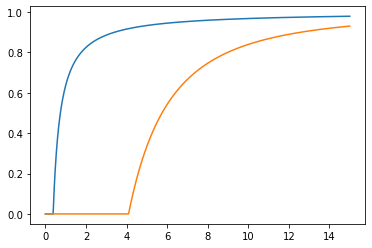

In [28]:

x = np.linspace(0,15,1000)

sns.lineplot(x=x, y=serv_par_105.cdf(x))
sns.lineplot(x=x, y=serv_par_205.cdf(x))

In [12]:
serv_par_105.median(), serv_par_105.mean()

(0.7371670693515371, 8.0)

Even though the mean time of the 2 pareto distributions are the same, the probability mass of the k=1.05 distribution is heavily weighted towards the beginning. i.e. the median is way to the left of the mean. Therefore, most of the costumers would be serviced very quickly, and the blocked costumers very low. Only with a huge simulation, the true amount of blocked costumers will appear.